## This notebook takes Q and c (s::can) input from Hungerford and Wade catchments and runs a slightly modified version of Wang and Carey's 2017's HydRun workflow in R for automatic baseflow separation and event delineation

- Data from SV's email on 05.23.24 (`hb_q_chem copy.csv`, etc) copied to sonya-may24/ directory
- Data range 2021-2023 winters

### To run this notebook:

- Change the `Site` and `Year` variables to your specifics under the `Set Site Info` section
- Change the parameters as desired in the `Baseflow separation and event delineation` section

WW TO DO:

- [x] dynamic read-in and write-out for sites
- [x] save out for event start and end times
- [ ] calculate event water and c yields

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“Removed 46873 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 46873 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 15040 rows containing missing values (`geom_line()`).”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 48919 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 76 rows

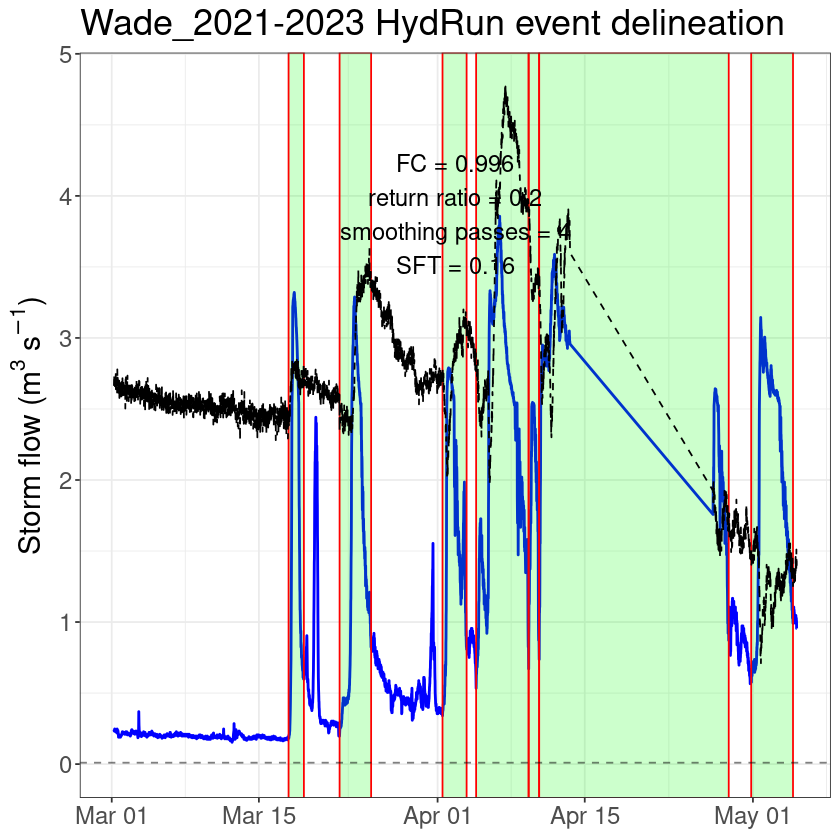

In [1]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(dplyr)
library(HydRun)

###################
# SET DIRECTORIES #
###################

input_dir <- "~//OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/data"
output_dir <- "~//OneDrive/git-repos/cQ_analysis/hydrun/output/newrnet"

#################
# SET SITE INFO #
#################

# Name the input data
Site <- "Wade"  # This can be changed dynamically
Year <- "2021-2023"
dataSetName <- paste(Site, Year, sep = "_")

# Determine site abbreviation and catchment area based on Site
site_info <- list(
  Hungerford = list(abb = "hb", Area = 48.1),
  Potash = list(abb = "pt", Area = 18.4),
  Wade = list(abb = "wb", Area = 16.7)
)

if (!is.null(site_info[[Site]])) {
  site_abb <- site_info[[Site]]$abb
  Area <- site_info[[Site]]$Area
} else {
  stop("Site not recognized. Please check the site name.")
}

################
# READ IN DATA #
################

# Generate the filename dynamically
file_name <- paste0(site_abb, "_q_chem.csv")

# Read in the data
hydrograph <- read.csv(file.path(input_dir, file_name)) %>%
  mutate(datetime = ymd_hms(datetime)) %>%
  drop_na(!!sym(paste0("q_cms_", site_abb)), NO3) %>% # Dynamically refer to the correct column
  select(datetime, q_cms = !!sym(paste0("q_cms_", site_abb)), conc = NO3) %>% 
  mutate(rescaled_conc = ((conc - min(conc)) / (max(conc) - min(conc)) * max(q_cms))) # Rescale the data

#######################
# BASEFLOW SEPARATION #
# + EVENT DELINEATION #
#######################

# Set RDF parameters
FC = 0.996
bf_passes = 3

# Set event extraction parameters
SFT = 0.16 # Dustin had 0.1 for Hford, 0.05 for Wade
return_ratio = 0.20 # Dustin had 0.1-0.18, I think should be higher for winter
beginning_slope = 0.001 # The beginning slope (slope threshold used to cut flat head)
end_slope = 0.35 # The ending slope (slope threshold to end event)
smoothing_passes = 4 # Dustin didn't specifiy - Millar used 4; should be higher for winter
minimum_duration = 96 # The minimum duration of a runoff event, expressed as the number of timesteps 
                      #24 hrs = 96 timesteps
dynamic_slope = 0.001 # The dynamic slope threshold used to cut the flat head and end the runoff event

# using 3 baseflow separation passes as in Millar example, also 0.996 as filter parameter as Kincaid 2020
hydrograph_separated <- separate.baseflow(hydrograph, filter = FC, passes = bf_passes)

# apply the runoff event extraction function
# this contains the same stormflow smoothing algorithm that the Millar code appropriates

# I'm using the defaults I can get from Kincaid 2020
runoff_events <- extract.runoff(hydrograph_separated$stormflow, 
                                min_diff = SFT, 
                                return_ratio = return_ratio, 
                                b_slope = beginning_slope, 
                                e_slope = end_slope, 
                                sc = smoothing_passes, # Millar example set to 4
                                min_dur = minimum_duration, # Dustin used 6 for Hford, 4 for Wade
                                dyslp = dynamic_slope)

#########################
# PLOT AND SAVE RESULTS #
#########################

# 1) Plot total discharge with baseflow

baseflowHydrograph <- ggplot() + 
    geom_line(data=hydrograph, aes(x=datetime, y=q_cms), 
        linewidth=0.5, color="black") +
    geom_line(data=hydrograph_separated$baseflow, aes(x=datetime, y=baseflow), 
       linewidth=0.75, color = "blue") +
    scale_color_brewer(palette = "Set1") +
    xlab(NULL) +
    ylab(expression(paste("Discharge (",m^3," ",s^-1,")"))) +
    scale_x_datetime(limits = as.POSIXct(c("2022-02-01 00:00:00", "2022-04-18 01:00:00"))) +
    theme_bw() +
    theme(legend.title = element_blank(),
    text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_Baseflows.jpeg")),
       baseflowHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)

# 2) Plot stormflow

stormflowHydrograph <- ggplot() + 
  geom_line(data=hydrograph, aes(x=datetime, y=q_cms), 
        linewidth=0.5, color="black") +
  geom_line(data=hydrograph_separated$stormflow, aes(x=datetime, y=stormflow), 
        linewidth=0.75, color = "blue") +
  scale_color_brewer(palette = "Set1") +
  xlab(NULL) +
  ylab(expression(paste("Storm flow (",m^3," ",s^-1,")"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_StormflowsOnly.jpeg")),
       stormflowHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)

# 3a) Plot smoothed storm flows with storm flow thresholds

# Combine all event dataframes into one
all_events <- do.call(rbind, lapply(names(runoff_events$RunoffEvents), function(event) {
  df <- runoff_events$RunoffEvents[[event]]
  df$event <- event
  df
}))

# Calculate the start and end times for each event
event_times <- all_events %>%
  group_by(event) %>%
  summarise(
    start = min(datetime),
    end = max(datetime),
    duration_hrs = (end - start) / 3600
  )

# Make a nice df to save event start and end times
# TO DO - add in water and c yields here
event_times_df <- event_times %>%
  # order chronologically by start time
  mutate(across(start, ymd_hms)) %>% arrange(start)

#water_yield_mm <- tot_q_m3 / (Area * 10^6) * 1000 
#constit_yield_mm <- tot_constit_mgN / (Area * 10^6) 

# Save the event times dataframe as a csv in the output directory
write.csv(event_times_df,file = file.path(output_dir,"Hydrographs", paste(dataSetName,"_HydRun_StormEventSummaryData.csv",sep="")))

stormflowThreshHydrograph <- ggplot(all_events, aes(x = datetime, y = event_stormflow, color = "0.99")) + 
  geom_line(linewidth = 0.75) +
  scale_color_brewer(palette = "Set1") +
  geom_hline(yintercept = 0.01, linetype = "dashed", color = "black", alpha = 0.5) +
  xlab(NULL) +
  ylab(expression(paste("Storm flow (", m^3, " ", s^-1, ")"))) +
  scale_x_datetime(limits = as.POSIXct(c("2022-02-01 00:00:00", "2022-04-18 01:00:00"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text = element_text(size = 18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_StormflowsOnlyWithThresholds.jpeg")),
       stormflowThreshHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)

# 4) Plot stormflow with shaded event durations

# Define the start and end of the x-axis range
start_datetime <- as.POSIXct("2023-03-01 00:00:00")
end_datetime <- as.POSIXct("2023-05-05 00:00:00")

# Calculate the midpoint of the x-axis range
midpoint_datetime <- start_datetime + (end_datetime - start_datetime) / 2

eventsDataShaded1 <- ggplot() + 
  geom_line(data = hydrograph, aes(x = datetime, y = q_cms), size = 0.8, color = "blue") +
  geom_rect(data = event_times, aes(xmin = start, xmax = end, ymin = -Inf, ymax = Inf), 
            fill = "green", color = 'red', alpha = 0.2, inherit.aes = FALSE) +
  geom_line(data = hydrograph, aes(x = datetime, y = rescaled_conc), size = 0.5, color = "black", linetype = "dashed") +
  geom_line(linewidth = 0.75) +
  scale_color_brewer(palette = "Set1") +
  geom_hline(yintercept = 0.01, linetype = "dashed", color = "black", alpha = 0.5) +
  xlab(NULL) +
  ggtitle(paste(dataSetName, "HydRun event delineation", sep = " ")) +
  ylab(expression(paste("Storm flow (", m^3, " ", s^-1, ")"))) +
  scale_x_datetime(limits = c(start_datetime, end_datetime)) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text = element_text(size = 18)) +
  # Add annotations at the midpoint
  annotate("text", x = midpoint_datetime, y = max(hydrograph$q_cms) * 0.9,        
           label = paste("FC = ", FC, sep = ""),
           hjust = 0.5, vjust = 1, size = 5, color = "black") +
  annotate("text", x = midpoint_datetime, y = max(hydrograph$q_cms) * 0.85, 
           label = paste("return ratio = ", return_ratio, sep = ""), 
           hjust = 0.5, vjust = 1, size = 5, color = "black") +
  annotate("text", x = midpoint_datetime, y = max(hydrograph$q_cms) * 0.8, 
           label = paste("smoothing passes = ", smoothing_passes, sep = ""), 
           hjust = 0.5, vjust = 1, size = 5, color = "black") +
  annotate("text", x = midpoint_datetime, y = max(hydrograph$q_cms) * 0.75, 
           label = paste("SFT = ", SFT, sep = ""),
           hjust = 0.5, vjust = 1, size = 5, color = "black")

# Save the plot with annotation
ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_BatchEventSeparationPlot_Annotated.jpeg")),
       eventsDataShaded1,
       width = 18, 
       height = 4, 
       units = "in",
       dpi=600)

eventsDataShaded1

# Quick calc of baseflow averages

In [2]:
# Whole baseflow timeseries
print(paste("entire dataset = ", (mean(hydrograph_separated$baseflow$baseflow))))

# Define the datetime limits
limits <- as.POSIXct(c("2022-02-01 00:00:00", "2022-04-18 01:00:00"))

# Filter the dataframe to include only the rows within the specified datetime range
filtered_baseflow <- hydrograph_separated$baseflow %>%
  dplyr::filter(datetime >= limits[1] & datetime <= limits[2])

# Same filter for q
filtered_q <- hydrograph %>%
  dplyr::filter(datetime >= limits[1] & datetime <= limits[2])

# Calculate the mean of the baseflow column within the specified datetime range
mean_baseflow <- mean(filtered_baseflow$baseflow, na.rm = TRUE)

# Calculate the mean of the baseflow column within the specified datetime range
mean_q <- mean(filtered_q$q_cms, na.rm = TRUE)

print(paste("Winter 2022 baseflow = ", mean_baseflow))
print(paste("Winter 2022 discharge = ", mean_q))

[1] "entire dataset =  0.319151663672626"
[1] "Winter 2022 baseflow =  0.798211266821019"
[1] "Winter 2022 discharge =  1.74064916668065"


In [3]:
runoff_events$RunoffEvents

,datetime,event_stormflow
,<dttm>,<dbl>
2,2021-12-02 18:15:00,0.009288318
3,2021-12-02 18:30:00,0.024072569
4,2021-12-02 18:45:00,0.024064761
5,2021-12-02 19:00:00,0.024056632
6,2021-12-02 19:15:00,0.034382707
7,2021-12-02 19:30:00,0.039688012
8,2021-12-02 19:45:00,0.056229680
9,2021-12-02 20:00:00,0.061945104
10,2021-12-02 20:15:00,0.056208134
